# Animal recognition for self-driving cars

VisionTech Solutions wants to develop an automatic image recognition system to distinguish between vehicles and animals, with the aim of optimizing wildlife monitoring operations in urban areas, avoiding road accidents and protecting both animals and vehicles.

VisionTech Solutions works with city governments to implement a real-time monitoring system in cities, using cameras installed along roads to identify and classify vehicles and animals. This system will help prevent road accidents caused by sudden crossing of animals by alerting drivers via electronic road signs.

Benefits:

1. **Process Automation:**
    - Reduced time and resources to manually monitor urban areas.
    - Automatic and real-time detection of animals and vehicles.
2. **Increased Accuracy:**
    - Use of a convolutional neural network (CNN) to ensure high precision in image classification.
    - Minimization of human errors.
3. **Operational Efficiency:**
    - Fast and accurate processing of large volumes of data, improving event response.
    - Greater safety for citizens and reduction of damage to vehicles.
4. **Multiple Applications:**
    - Traffic surveillance and monitoring.
    - Analysis of animal behavior in urban areas.
    - Use of data to improve road safety policies.

**Project Details:**

1. **Dataset:**
    - Use of the CIFAR dataset, containing thousands of images labeled in various categories, including vehicles and animals.
2. **Algorithm:**
    - Implementation of a convolutional neural network (CNN) for image analysis and classification.
3. **Output:**
    - The system will correctly classify each image as a vehicle or animal.

**Model Evaluation:**
    
- **Accuracy:** Proportion of images classified correctly compared to the total.
- **Precision:** Quality of positive predictions, indicating the proportion of correctly identified images.

**Results Analysis:**

- Identification of any error patterns.
- Evaluation of systematically confused image categories.
- Examination of incorrect images and reflection on possible improvements to the model.

**Final Result:**

- Comprehensive presentation of the convolutional neural network and its vehicle-animal discrimination capabilities.
- Detailed discussion of the metrics used and a critical analysis of the model's performance and limitations.

This project will provide VisionTech Solutions with an effective system to improve road safety and wildlife management in urban areas, demonstrating practical skills in applying machine learning to image recognition.

# Environment set up

In [ ]:
# Library import
import os
import pickle
import warnings
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.backend import clear_session
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import InputLayer, Input, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import MaxPool2D, BatchNormalization
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout

# Say no to warnings!
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Data preparation

Let's start by importing the [CIFAR dataset](https://www.cs.toronto.edu/~kriz/cifar.html) and proceed with an initial exploratory analysis.

In [ ]:
# Import the CIFAR dataset (subset 10 for computational simplicity)
cifar10 = tf.keras.datasets.cifar10

# Train - test split
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# The order of the labels is defined by the official documentation of the dataset
labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

# Mapping of the index (0 - 9) in 0 = vehicle, 1 = animal
label_class = {0: 'vehicle', 1: 'animal'}
label_map = [0,0,1,1,1,1,1,1,0,0]

# Check dataset label values and shape
print(f'Train label: {np.unique(y_train, return_counts=True)}')
print(f'Train shape\n- X: {x_train.shape},\n- Y: {y_train.shape}')
print(f'\nTest label: {np.unique(y_test, return_counts=True)}')
print(f'Test shape\n- X: {x_test.shape},\n- Y: {y_test.shape}')

Train label: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))
Train shape
- X: (50000, 32, 32, 3),
- Y: (50000, 1)

Test label: (array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8), array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))
Test shape
- X: (10000, 32, 32, 3),
- Y: (10000, 1)


Based on an initial analysis, and consistently with what is indicated in the documentation, we have 60'000 32x32 color images in 10 classes, therefore 6'000 images per class.

Label: bird
Class: animal


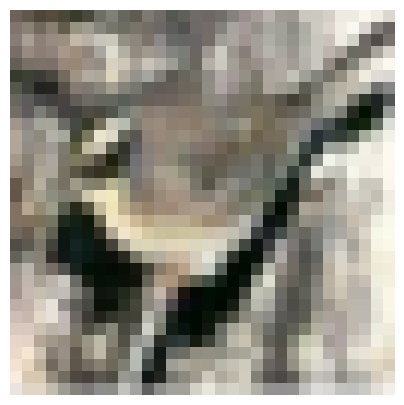

In [ ]:
# Plot a random image from the train dataset
plt.figure(figsize = (5, 5))
indx = np.random.choice(range(50000))
plt.imshow(x_train[indx])
plt.axis('off')

# Classification
print(f'Label: {labels[y_train[indx][0]]}\nClass: {label_class[label_map[y_train[indx][0]]]}')

In [ ]:
# Train dataset
y_train_bin = np.array([label_map[label[0]] for label in y_train])
y_train_bin

array([1, 0, 0, ..., 0, 0, 0])

In [ ]:
# Check target feature balance
np.unique(y_train_bin, return_counts=True)

(array([0, 1]), array([20000, 30000]))

In [ ]:
# Test dataset
y_test_bin = np.array([label_map[label[0]] for label in y_test])
y_test_bin

array([1, 0, 0, ..., 1, 0, 1])

In [ ]:
# Check target feature balance
np.unique(y_test_bin, return_counts=True)

(array([0, 1]), array([4000, 6000]))

In [ ]:
# Train dataset normalization and flatten label array
x_train, x_test = x_train / 255.0, x_test / 255.0
y_train_bin, y_test_bin = y_train_bin.flatten(), y_test_bin.flatten()

# Model implementation

In [ ]:
# Session cleaning
clear_session()

The neural network is composed as follows:

- **Conv2D:** uses Conv2D with different numbers of filters (32, 64, 128) and a (3, 3) kernel size. Each filter scans the input image to detect features:
    - *activation = 'relu':* makes the model nonlinear and get only the most important features;
    - *input_shape = (32, 32, 3):* defines the size of the input images: 32x32 pixels with 3 color channels (RGB);
    - *padding = 'same':* ensures the output feature map has the same height and width as the input, preventing the image from shrinking too quickly.

- **BatchNormalization:** normalizes the activations of the previous layer. It helps stabilize the learning process, allowing the network to train faster and be less sensitive to the initial weights.

- **MaxPooling2D:** downsamples the feature map by taking the maximum value from a specified region (in this case, (2,2)). This reduces the dimensionality of the data, which makes the model more efficient and less prone to overfitting.

    The following convolutional layers have twice as many filters as in the previous layers (32, 64, 128) in order to extract more features from the images.  

- **Flatten:** reshapes the multi-dimensional output of the convolutional layers into a single, long vector. This is necessary because the fully connected layers that follow can only process 1D vectors.

- **Dense**: the standard neural network layers. They take the flattened features and learn the final relationships needed for classification:
    - The first two Dense layers (128 and 64 neurons) are "hidden" layers that process the features.
    - The final Dense layer has 1 neuron because it's a binary classification problem ("sigmoid" activation).

- **Dropout:** a regularization technique. It randomly "turns off" a fraction of neurons (0,5 or 0,3) during training. This prevents the network from relying too much on specific neurons, which helps to reduce overfitting.

- **Compile:** configures the model for training
    - *optimizer = 'adam':* is the algorithm that adjusts the network's weights to minimize the loss.
    - *loss = 'binary_crossentropy':* measures how well the model is performing. For binary classification problems, binary_crossentropy is the standard choice.
    - *metrics = ['accuracy']:* track the model's performance. Accuracy simply measures the percentage of correct predictions.

In [ ]:
# CNN structure
cnn = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3), padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation = 'relu', padding = 'same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),

    Dense(128, activation = 'relu'),
    Dropout(0.5),
    Dense(64, activation = 'relu'),
    Dropout(0.3),

    Dense(1, activation = 'sigmoid')
])

cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,737 (1.39 MB)

 Trainable params: 364,289 (1.39 MB)

 Non-trainable params: 448 (1.75 KB)

In order to prevent overfitting and stop the training phase at the moment when the validation loss no longer seems to go down, the model include an "early stopping" regularization technique.

In [ ]:
# Early stopping
early_stopping = EarlyStopping (
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

In [ ]:
# Model training
hist1 = cnn.fit(
    x_train,
    y_train_bin,
    validation_data = (x_test, y_test_bin),
    epochs = 50,
    callbacks = [early_stopping],
)

Epoch 1/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 157s 98ms/step - accuracy: 0.8524 - loss: 0.3784 - val_accuracy: 0.8809 - val_loss: 0.2751
Epoch 2/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 150s 96ms/step - accuracy: 0.9169 - loss: 0.2186 - val_accuracy: 0.8956 - val_loss: 0.2509
Epoch 3/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 149s 95ms/step - accuracy: 0.9334 - loss: 0.1792 - val_accuracy: 0.8943 - val_loss: 0.2448
Epoch 4/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 154s 99ms/step - accuracy: 0.9409 - loss: 0.1561 - val_accuracy: 0.9340 - val_loss: 0.1623
Epoch 5/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.9508 - loss: 0.1355 - val_accuracy: 0.9086 - val_loss: 0.2040
Epoch 6/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 152s 97ms/step - accuracy: 0.9544 - loss: 0.1184 - val_accuracy: 0.9416 - val_loss: 0.1495
Epoch 7/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 156s 100ms/step - accuracy: 0.9629 - loss: 0.0969 - val_accuracy: 0.9415 - val_loss: 0.1501
Epoch 8/50
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 165s 105ms/step - accuracy

# Performance evaluation

First let’s see how the neural network works on a random image taken from the dataset.

Real: animal
Predicted: animal
Accuracy: 98%


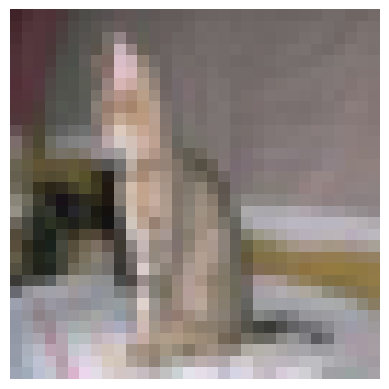

In [ ]:
# Check CNN classification on a random image from the dataset
index = np.random.randint(0, len(x_test))
img = x_test[index]
label_reale = y_test_bin[index]

img_input = np.expand_dims(img, axis=0)

prediction = cnn.predict(img_input, verbose=0)
pred_label = (prediction > 0.5).astype(int)

label_map = {0: 'vehicle', 1: 'animal'}

print(f'Real: {label_map[label_reale]}')
print(f'Predicted: {label_map[pred_label[0][0]]}')
print(f'Accuracy: {int(100 * prediction[0][0])}%')

plt.imshow(img)

plt.axis("off")
plt.show()

Let’s now check the general performance of the implemented model.

In [ ]:
# Check test accuracy and loss values
loss, accuracy = cnn.evaluate(x_test, y_test_bin, verbose=0)

print(f'Test accuracy: {accuracy:.2f}')
print(f'Test loss: {loss:.2f}')

Test accuracy: 0.94
Test loss: 0.14


Based on the test datatsets, CNN creates an accuracy of approximately **94%**, with a loss value of around **15%**.

In [ ]:
# Classification report
y_pred = cnn.predict(x_test, verbose=0)
y_pred = (y_pred > 0.5).astype(int)
print(classification_report(y_test_bin, y_pred, target_names=['Animal', 'Vehicle']))

              precision    recall  f1-score   support

      Animal       0.96      0.90      0.93      4000
     Vehicle       0.93      0.98      0.95      6000

    accuracy                           0.94     10000
   macro avg       0.95      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



From the test data classification report we can generally notice good values on the various metrics. Only a slightly better F1-score should be noted on the "Animal" lable compared to "Vehicle", which can however be attributed to the imbalance of the dataset between the two labels (6000 - 4000).

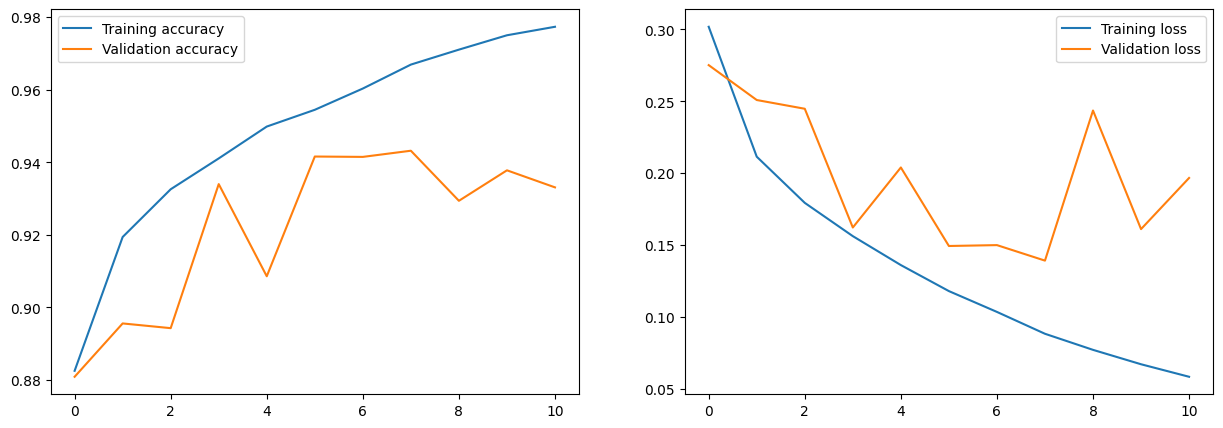

In [ ]:
# Accuracy and loss value over epochs
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist1.history['accuracy'], label='Training accuracy')
plt.plot(hist1.history['val_accuracy'], label='Validation accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(hist1.history['loss'], label='Training loss')
plt.plot(hist1.history['val_loss'], label='Validation loss')
plt.legend();

According to the graphs in the first 10 training eras:

- **accuracy** is on an increasing trend;
- **loss** is on a decreasing trend.

Furthermore, by analyzing **validation accuracy** and **validation loss** in detail, we can notice a trend that tends to be in line with the respective metrics, even if the oscillation indicates potential fluctuations in the model learning process.

# Display of results

Finally, let's check the results achieved.

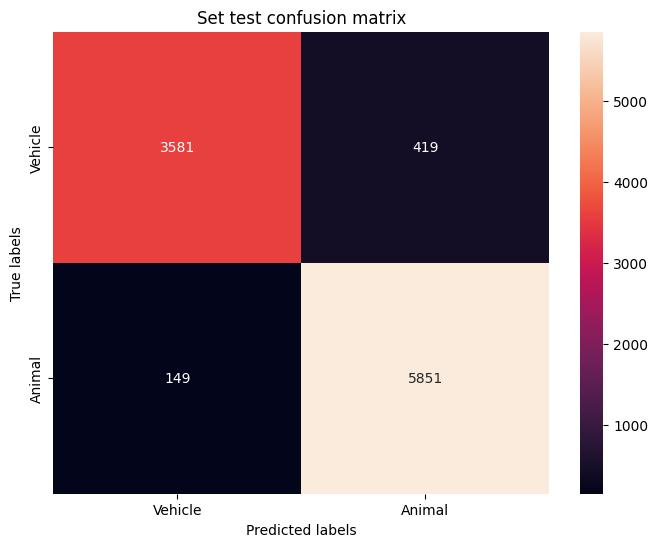

In [ ]:
# Plot test confusion matrix
cm = confusion_matrix(y_test_bin, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    xticklabels = ['Vehicle', 'Animal'],
    yticklabels = ['Vehicle', 'Animal'],
)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Set test confusion matrix')
plt.show()

The confusion matrix confirms the excellent classification ability of the model, as can be expected from the analyzed metrics. It is also possible to see how images of animals are classified more accurately than images of vehicles.

# Conclusions

The project successfully developed a convolutional neural network (CNN) for image analysis and classification. The objective was to create an automatic system to distinguish between vehicles and animals, improving road safety and urban wildlife management.

The model was built and evaluated using the **CIFAR dataset**, which includes thousands of labeled images. The dataset was split into training and testing sets, and the data was normalized to improve model performance.

The CNN architecture was designed with multiple convolutional and max-pooling layers to extract features, followed by a flatten layer and dense layers for classification. The model's performance was evaluated using standard metrics such as accuracy and precision, with the results indicating excellent overall performance.

Going into detail, performance is slightly better in terms of animal classification than vehicles. This may be due to the fact that, despite a good general balance of the dataset, the animal class is slightly more represented than the vehicle class. However, considering the cost of error on animals could be more critical, the model is to be considered reliable.

In summary, this project demonstrates a practical application of machine learning for image recognition, providing a robust solution for VisionTech Solutions to enhance road safety and wildlife management in urban environments.